## Imports

In [9]:
from pathlib import Path

import sleap
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
mpl.style.use("seaborn-v0_8-deep")
sleap.versions()

SLEAP: 1.3.1
TensorFlow: 2.9.2
Numpy: 1.22.4
Python: 3.9.15
OS: macOS-14.0-arm64-arm-64bit


In [11]:
data_dir = Path.home() / "Data" / "behav-analysis-course" / "mouse-EPM"
sleap_project_dir = data_dir / "derivatives" / "behav" / "software-SLEAP_project"

assert sleap_project_dir.exists()

In [12]:
help(sleap.load_metrics)

Help on function load_metrics in module sleap.nn.evals:

load_metrics(model_path: str, split: str = 'val') -> typing.Dict[str, typing.Any]
    Load metrics for a model.
    
    Args:
        model_path: Path to a model folder or metrics file (.npz).
        split: Name of the split to load the metrics for. Must be `"train"`, `"val"` or
            `"test"` (default: `"val"`). Ignored if a path to a metrics NPZ file is
            provided.
    
    Returns:
        The loaded metrics as a dictionary with keys:
    
        - `"vis.tp"`: Visibility - True Positives
        - `"vis.fp"`: Visibility - False Positives
        - `"vis.tn"`: Visibility - True Negatives
        - `"vis.fn"`: Visibility - False Negatives
        - `"vis.precision"`: Visibility - Precision
        - `"vis.recall"`: Visibility - Recall
        - `"dist.avg"`: Average Distance (ground truth vs prediction)
        - `"dist.p50"`: Distance for 50th percentile
        - `"dist.p75"`: Distance for 75th percentile
  

In [13]:
centroid_model_path = sleap_project_dir / "models" / "231122_133449.centroid"
centered_instance_model_path = sleap_project_dir / "models" / "231122_133449.centered_instance"

In [32]:
centroid_train_metrics = sleap.load_metrics(centroid_model_path, split="train")
centroid_val_metrics = sleap.load_metrics(centroid_model_path, split="val")
centered_instance_train_metrics = sleap.load_metrics(centered_instance_model_path, split="train")
centered_instance_val_metrics = sleap.load_metrics(centered_instance_model_path, split="val")

metrics_dict = {
    "centroid_train": centroid_train_metrics,
    "centroid_val": centroid_val_metrics,
    "centered_instance_train": centered_instance_train_metrics,
    "centered_instance_val": centered_instance_val_metrics,
}
#help(sleap.load_metrics)
#print("\n".join(metrics.keys()))

In [80]:
def print_distance_percentiles(metrics, percentile=95):
    dist_perc = metrics[f"dist.p{percentile}"]
    print(f"\t{percentile}%: {dist_perc:.4f} px")

print("Error distance:")
for name, metrics in metrics_dict.items():
    print(f"\n{name}")
    for dist_percentile in [50, 90, 95]:
        print_distance_percentiles(metrics, dist_percentile)

Error distance:

centroid_train
	50%: 0.0000 px
	90%: 0.0000 px
	95%: 0.0000 px

centroid_val
	50%: 0.0000 px
	90%: 0.0000 px
	95%: 0.0000 px

centered_instance_train
	50%: 1.4793 px
	90%: 2.5119 px
	95%: 2.9337 px

centered_instance_val
	50%: 3.0762 px
	90%: 7.1631 px
	95%: 11.2406 px


In [66]:
def plot_localization_error_hist(metrics, title="", ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    dists = metrics["dist.dists"].flatten()
    sns.histplot(dists, stat="probability", ax=ax, **kwargs)
    ax.set_xlabel("Localization error (px)")
    ax.set_ylabel("Probability")
    ax.set_title(title)

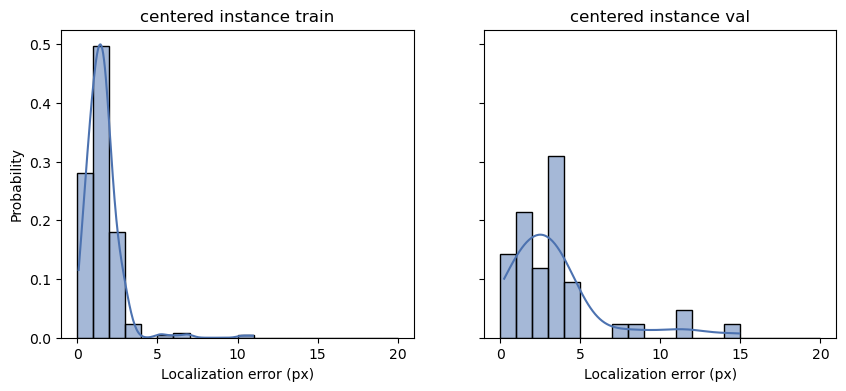

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

shared_kwargs = dict(binrange=(0, 20), binwidth=1, kde=True)

plot_localization_error_hist(
    centered_instance_train_metrics,
    title="centered instance train",
    ax=axs[0],
    **shared_kwargs
)

plot_localization_error_hist(
    centered_instance_val_metrics,
    title="centered instance val",
    ax=axs[1],
    **shared_kwargs
)

In [82]:
def plot_oks(metrics, title="", ax=None, **kwargs):
    """Plots Object Keypoint Similarity (OKS) histogram."""
    if ax is None:
        ax = plt.gca()
    oks = metrics["oks_voc.match_scores"].flatten()
    sns.histplot(oks, stat="probability", binrange=(0,1), ax=ax, **kwargs)
    ax.set_xlabel("Object Keypoint Similarity (OKS)")
    ax.set_ylabel("Probability")
    ax.set_title(title)

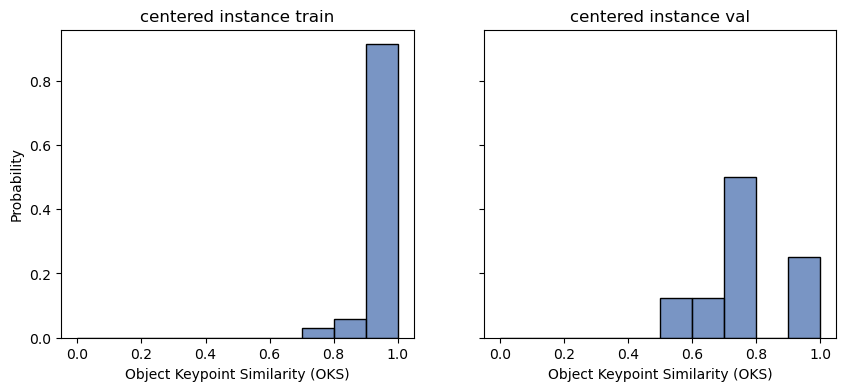

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

plot_oks(
    centered_instance_train_metrics,
    title="centered instance train",
    binwidth=0.1,
    ax=axs[0],
)

plot_oks(
    centered_instance_val_metrics,
    title="centered instance val",
    binwidth=0.1,
    ax=axs[1],
)